# MCAA project
By D. Kovac, M. Pariset and Y. Saied

## 0. Setup

In [ ]:
# !pip install ray

In [ ]:
import scipy.stats as st
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random
import timeit
import itertools
import math
from sklearn.metrics.pairwise import euclidean_distances
import ray
import pickle as pkl

----

## 1. Cities distributions

In [ ]:
class DatasetGenerator(object):
  def __init__(self, N=100):
    self.N = N
    self.x = None
    self.v = None
    self.refresh()

  def refresh(self):
    raise Exception("undefined")

In [ ]:
class G1(DatasetGenerator):
  def refresh(self):
    self.x = st.uniform().rvs((self.N,2))
    self.v = st.uniform().rvs((self.N,))

In [ ]:
class G2(DatasetGenerator):
  def refresh(self):
    self.x = st.uniform().rvs((self.N,2))
    self.v = np.exp(st.norm(-0.85, 1.3).rvs((self.N,)))

In [ ]:
g1 = G1()
g2 = G2()

In [ ]:
# g1.refresh()
# g2.refresh()

### Plot distributions

In [ ]:
def plot_distribution(distr):
  # Plot a histogram of the v array
  plt.hist(distr.v, bins=30)
  plt.show()

  # plot the position of the points
  plt.figure(figsize=(5,5))
  plt.scatter(distr.x[:,0], distr.x[:,1])
  plt.show()

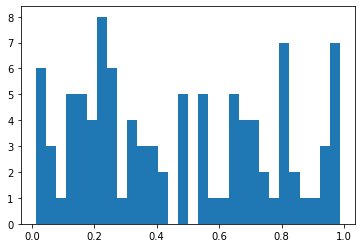

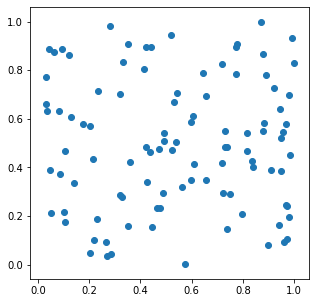

In [ ]:
plot_distribution(g1)

---

## 2. Metropolis-Hastings

#### Specify distribution used

In [ ]:
x, v = g2.x, g2.v
cities=(x, v)

#### Objective function

In [ ]:
# The objective function
def f(N, l, x, v):
  if x.shape[0] == 0:
    return 0
  else:
    return v.sum() - l * N * np.pi * np.max(np.power(euclidean_distances(x,x), 2)) / 4

#### Types of base chains

In [ ]:
## Different kinds of chain

# Simple random walk chain
def simple_chain(initial_state):
  city = np.random.randint(0, len(initial_state))
  proposed_state = initial_state.copy()
  proposed_state[city] =  not proposed_state[city] # Change invert decision on 'city'
  return proposed_state

# Entirely random walk chain
def random_chain(initial_state):
  return np.random.choice(a=[False, True], size=(len(initial_state),))

def combination_chain(initial_state, convexity_parameter):
  """
  convexity_parameter =1 ==> simple
  """
  return simple_chain(initial_state) if random.uniform(0,1) < convexity_parameter else random_chain(initial_state)

### Simulated Annealing implementation

In [ ]:
# A State is a vector of True and False, indicating the presence (respectively) absence of a city
def get_state(state, x, v):
  return x[state], v[state]

def next_state(l, t, x, v, previous_state, f, chain):
  """
  Adds or removes one city from the state at random
  using the Metropolis-Hastings algorithm.

  Parameters:
  l: lambda
  t: temperature
  x: list of positions
  v: populations (values)
  previous_state: previous state
  f: objective function
  chain: a function that should recieve a state
    and propose a new state from a given markov chain

  Returns
  -------
  new_state
    the state after this random adjustement.
  new_val
    the value of the function at 'new_state'
  """
  # Propose a city to change,
  # here we pick a 'neighbouring state'
  # but it would also be posssible to pick one at random

  proposed_state = chain(previous_state)

  # Decide whether to accept the proposed state or not
  x_initial, v_initial = get_state(previous_state, x, v)
  x_proposed, v_proposed = get_state(proposed_state, x, v)

  # Sanity check
  assert x_proposed.shape[0] == v_proposed.shape[0]

  N = x.shape[0]
  val_initial = f(N, l, x_initial, v_initial)
  val_proposed = f(N, l, x_proposed, v_proposed)

  if val_proposed >= val_initial or random.random()<np.exp((val_proposed - val_initial)/t): # the coeff. in the exponent is positive, since we look for the max
    new_state, new_val = proposed_state, val_proposed
  else:
    new_state, new_val = previous_state, val_initial

  return new_state, new_val

In [ ]:
def simulated_annealing(lmb, num_steps, t_initial, objective_f, cities, annealing_strategy, chain=lambda _ : combination_chain(_,1), initial_state=None):
  """
  Runs the Simulated Annealing algorithm, using given initial parameters and annealing strategy

  Parameters:
  lmb: lambda
  num_steps: the number of steps
  t_initial: initial temperature
  objective_f: the objective function
  cities: positions and populations of cities
  annealing_strategy: a cooling function (see 'to_cooling()')
  chain: a function that receives a state and outputs a new state (base chain)
  initial_state: the initial state on the base chain

  Returns
  -------
  best
    a dictionary containing:
    - "proposed": the list of chosen cities which achieves the best value of the objective function
     - "max": the maximum value of the objective function
   value_list
     a list containing the value of the objective function at each iteration
   temps
     a list containing the temperature at each iteration
  """
  x, v = cities
  N = len(x)

  if initial_state is None:
    # The default initial state is selected uniformly at random
    initial_state = np.random.choice(a=[False, True], size=(N,))

  proposed_state, value = next_state(lmb, t=t_initial, x=x, v=v, f=objective_f,
                                   previous_state=initial_state, chain=chain)
  value_list = []
  max_value= value
  value = value
  max_proposed_state= initial_state
  i = 0
  t = t_initial

  temps = []

  while i<num_steps:
    i=i+1
    t = annealing_strategy(t_initial, t, i, max_value, value)
    proposed_state, value = next_state(lmb, t, x, v, f=objective_f, previous_state=proposed_state, chain=chain)
    value_list.append(value)
    temps.append(t)

    if value>max_value:
      max_proposed_state = proposed_state
      max_value=value

  best = {"proposed": max_proposed_state, "max": max_value}
  return best, value_list, temps

In [ ]:
def to_cooling(strategy):
  """
  Transforms a strategy (i.e. a function of: (1) initial_T, (2) current_T, (3) iteration_number and (4) alpha,
  returning the new temperature) into full-fledged, possibly adaptive, cooling function.

  The cooling function depends on:
    (1) T_init: initial temperature
    (2) T: current temperature
    (3) i: current iteration
    (4) past_best: maximum reached so far
    (5) current_val: value of the objective function at current state

  Parameters:
  strategy: one strategy contained in 'annealing' dictionary

  Returns
  -------
  _config_strategy
    A constructor of a cooling function (which takes as argument the value of 'alpha')
  """

  # Takes 'alpha' and 'is_adaptive' and returns an actual cooling strategy
  def _config_strategy(alpha, is_adaptive=False):
    # Actual 'adaptive' cooling strategy
    def _adaptive_cooling(T_init, T, i, past_best, current_val):
      temp_proposal = strategy(T_init, T, i, alpha)
      if current_val != 0:
        m_coeff = 1 + past_best / current_val
      else:
        m_coeff = 1

      # Sanity check
      assert 1 <= m_coeff and m_coeff <= 2, m_coeff

      return m_coeff * temp_proposal

    # Actual 'monotonic' cooling strategy
    def _non_adaptive_cooling(T_init, T, i, past_best=None, current_val=None):
      return strategy(T_init, T, i, alpha)

    if is_adaptive:
      return _adaptive_cooling
    else:
      return _non_adaptive_cooling

  return _config_strategy

In [ ]:
# List of available strategies
annealing = {
    "exponential": to_cooling(lambda T_init, T, i, alpha: T_init*np.power(alpha, i)),
    "linear": to_cooling(lambda T_init, T, i, alpha: T_init  / (i * alpha + 1)),
    # See [1]
    "logarithmic": to_cooling(lambda T_init, T, i, alpha: T_init/(1+alpha*(np.log(1+i)))),
    "quadratic_mult": to_cooling(lambda T_init, T, i, alpha: T_init/(1+alpha*i*i)),
    # from survey paper
    "lundy_mees": to_cooling(lambda T_init, T, i, alpha: T/(1+alpha*(T))),
}

In [ ]:
def generate_init_state(N, inclusion_prob):
  """
  Returns a random initial state, in which each city has a given probability of being selected

  Parameters:
  N: number of cities
  inclusion_prob: probability that any given city is selected

  Returns
  -------
  An initial random state
  """
  return np.random.random(N) < inclusion_prob

### Testbench

#### a. Convex. Empty set of cities

In [ ]:
# The maximum of this function is attained without any city
def f_test_empty(N, l, x, v):
  return - v.T @ v

#### b. Convex. Full set of cities

In [ ]:
# The maximum of this function is attained with all cities
def f_test_full(N, l, x, v):
  return v.T @ v

#### c. Non-convex. Isolated hotspots
This tests, selects 4 (very distant) cities. The maximum is achieved by selecting those.

In [ ]:
# Set the location of cities to use
test_cities = cities[0]
hotspots_num = 5

In [ ]:
cities_by_x = test_cities[np.argsort(test_cities[:,0]),:]
cities_by_y = test_cities[np.argsort(test_cities[:,1]),:]

In [ ]:
min_x_props = cities_by_x[:4*hotspots_num,:]
max_x_props = cities_by_x[-4*hotspots_num:,:]
# @Youssef: Changed -+3 to -+4
min_y_props = cities_by_y[:4*hotspots_num,:]
max_y_props = cities_by_y[-4*hotspots_num:,:]

In [ ]:
# Select sparse hotspots
hotspots = np.zeros((4, 2))
hotspots[0,0] = np.intersect1d(min_x_props[:,0], min_y_props[:,0])[0]
hotspots[1,0] = np.intersect1d(min_x_props[:,0], max_y_props[:,0])[0]
hotspots[2,0] = np.intersect1d(max_x_props[:,0], min_y_props[:,0])[0]
hotspots[3,0] = np.intersect1d(max_x_props[:,0], max_y_props[:,0])[0]

In [ ]:
for i in range(4):
  hotspots[i,1] = cities_by_y[np.argmin(np.abs(cities_by_y[:,0] - hotspots[i, 0])), 1]

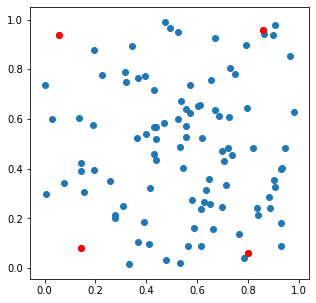

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(cities[0][:, 0], cities[0][:, 1])
plt.scatter(hotspots[:,0], hotspots[:,1], color="red", zorder=1)
plt.show()

In [ ]:
def isolated_hotspots(N, l, x, v):
  return 10*np.intersect1d(hotspots[:,0], x[:,0]).shape[0]

In [ ]:
score_simple = 0
hist_simple = []
for iters in range(100):
  single_res = simulated_annealing(lmb=.003, num_steps=100, t_initial=1e3, objective_f=isolated_hotspots, cities=cities, annealing_strategy=annealing["exponential"](.004), chain=lambda x: combination_chain(x,1))
  score_simple += single_res[1][-1]
  hist_simple.append(single_res[1])

In [ ]:
score_random = 0
hist_random = []
for iters in range(100):
  single_reg = simulated_annealing(lmb=.003, num_steps=100, t_initial=1e3, objective_f=isolated_hotspots, cities=cities, annealing_strategy=annealing["exponential"](.004), chain=lambda x: combination_chain(x,0))
  score_random += single_res[1][-1]
  hist_random.append(single_res[1])

In [ ]:
score_simple / 100, score_random / 100

(32.0, 40.0)

#### d. Optimal initial temperature & state

In [ ]:
def plot_dynamics(values, temperatures):
  steps = np.arange(0, len(values), 1)
  max_values = np.maximum.accumulate(values)
  max_value = max_values[-1]
  nearly_max= list(map(lambda x: int(np.absolute(x-max_value)/np.absolute(max_value+0.001)<0.01) ,values))
  steps_to_converge= np.argmax(nearly_max)
  print("steps: %d \t max: %.3f" % (steps_to_converge, max_value))

  fig, axs = plt.subplots(1, 2, figsize=(15, 6))
  axs[0].plot(steps, values)
  axs[0].set_xlabel("Step")
  axs[0].set_ylabel("Value")
  axs[0].set_title("Values")
  axs[1].plot(steps, temperatures)
  axs[1].set_xscale('log')
  axs[1].set_yscale('log')
  axs[1].set_xlabel("Step")
  axs[1].set_ylabel("Temperature")
  axs[1].set_title("Temperatures")
  plt.show()

In [ ]:
_, values, temperatures = simulated_annealing(cities =cities, objective_f=f, lmb=.1,
                                              num_steps = 1e5, t_initial=1e2,
                                              annealing_strategy=annealing["linear"](0.05),
                                              chain=(lambda initial_state : combination_chain(initial_state, 1)),
                                              initial_state=generate_init_state(len(cities[1]), .5))

steps: 12417 	 max: 74.393


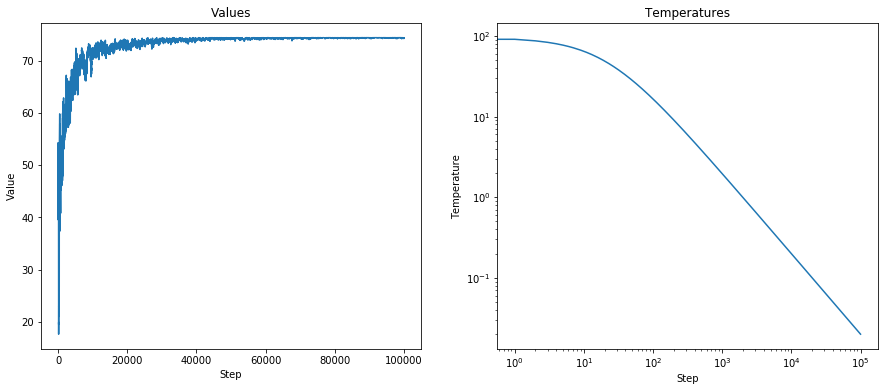

In [ ]:
plot_dynamics(values, temperatures)

###### Samples of manual test to figure out the effect of meta-parameters
$\alpha = 0.05$

|lambda | init_state (% of cities) | init_temp | steps | | optimal value | % cities selected| comments |
|:-----:|:----:|:----:|:------:|:-----:|:-----:|:------:|:------|
|1|10|1e4|5e5||3|10||
|1|**0**|1e4|5e5||3|10|zero cities at the beginning is better|
|1|0|1e4|**3e5**||3|6|the maximum is reached at the very end|
|1|0|**1e3**|3e5||3|6|the maximum is reached faster, before T0 was too high|
|1|0|**<1e3**|3e5||-10|-|the temperature is too low|
|**.7**|0|1e4|**1e6**||1.5|28||
|**.5**|**50**|**1e4**|1e6||7|62||
|.5|50|**1e3**|1e6||4|80||
|.5|50|**1e4**|1e5||6|58||
|**.3**|50|**1e3**|1e5||22|79||
|.3|50|**1e2**|1e5||22|89|this low temperature is more than enough|
|.1|50|1e2|1e5||42|97||


### Parallel computation of optimal values
Set the right number of **cores** to use, for a better use of your CPU!

In [ ]:
# Set the number of cores available
ray.init(num_cpus=4)

2020-12-13 20:32:36,284	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '192.168.43.10',
 'raylet_ip_address': '192.168.43.10',
 'redis_address': '192.168.43.10:6379',
 'object_store_address': 'tcp://127.0.0.1:64150',
 'raylet_socket_name': 'tcp://127.0.0.1:64452',
 'webui_url': '127.0.0.1:8265',
 'session_dir': 'C:\\Users\\Matteo\\AppData\\Local\\Temp\\ray\\session_2020-12-13_20-32-35_521194_2176',
 'metrics_export_port': 63493,
 'node_id': '89a7bf9e0ac3414544d538fe78657c7b8a3c2da4'}

2020-12-13 20:32:38,913	WARNING worker.py:1091 -- The dashboard on node DESKTOP-GMJ6612 failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Matteo\Anaconda3\lib\site-packages\ray\dashboard\dashboard.py", line 962, in <module>
    metrics_export_address=metrics_export_address)
  File "C:\Users\Matteo\Anaconda3\lib\site-packages\ray\dashboard\dashboard.py", line 512, in __init__
    build_dir = setup_static_dir(self.app)
  File "C:\Users\Matteo\Anaconda3\lib\site-packages\ray\dashboard\dashboard.py", line 411, in setup_static_dir
    "&& npm run build)", build_dir)
FileNotFoundError: [Errno 2] Dashboard build directory not found. If installing from source, please follow the additional steps required to build the dashboard(cd python/ray/dashboard/client && npm ci && npm run build): 'C:\\Users\\Matteo\\Anaconda3\\lib\\site-packages\\ray\\dashboard\\client/build'



In [ ]:
# Use this to shutdown the multithreading system
# ray.shutdown()

In [ ]:
# Repeats the execution of simulated_annealing a 'trials' number of times, and records the best result
# returns: [best_cities, maximum], [best_evolution_values], [oscillations_of_max_values]
@ray.remote(num_cpus=1)
def robust_simulated_annealing(config, trials=1):
  """
  [PARALLELIZABLE]
  Run multiple times Simulated Annealing and takes the best value

  Parameters:
  config: dictionary containing the parameters for SA algorithm
  trials: the number of times the algorithm is run

  Returns
  -------
  best
    the 'best' dictionary returned by the winning SA repetition
  values_hist
    the 'values_list' returned by the winning SA repetition
  oscillations
    the list of maxima (one per repetition)
  """
  # Extract configuration
  cities = config["cities"]
  f = config["objective_f"]
  lmb = config["lmb"]
  num_steps = config["num_steps"]
  t_initial = config["t_initial"]
  annealing_strategy = config["annealing_strategy"]
  chain = config["chain"]
  initial_state = config["initial_state"]

  best, values_hist = None, None

  prev_max = -math.inf

  # Records all the outcomes (for statistical analysis)
  oscillations = []

  for i in range(trials):
      best_trial, vals_trial, _ = simulated_annealing(
          cities=cities,
          objective_f=f,
          lmb=lmb,
          num_steps=num_steps,
          t_initial=t_initial,
          annealing_strategy=annealing_strategy,
          chain=chain,
          initial_state=initial_state
      )

      oscillations.append(best_trial["max"])

      if best_trial["max"] > prev_max:
          prev_max = best_trial["max"]
          best, values_hist = best_trial, vals_trial

  return best, values_hist, oscillations

In [ ]:
def find_max_by_lambda(global_config, steps_num_range, init_temp_range):
  """
  Finds the maximum of the 'objective_f' for a given value of lambda. It exploits available multithreading several values
  of number of steps and initial temperature

  Parameters:
  global_config: the configuration of SA algorithm
  steps_num_range: the range of 'num_steps' values to explore
  init_temp_range: the range of 't_initial' values to explore

  Returns
  -------
  highest_max
    the highest maximum found
  best_cities
    the best configuration of cities found
  best_metaparams
    a dictionary containing
    - num_steps: the number of steps achieving the best result
    - t_initial: the initial temperature achieving the best result
    - oscillations: the fluctuation of this optimal value (as given by 'robust_simulated_annealing()')
  """
  best_cities = []
  highest_max = -math.inf
  best_metaparams = {"num_steps": 0, "t_initial": 0, "oscillations": None}

  cycle_counter = 0
  tot_cycles = len(steps_num_range) * len(init_temp_range)

  futures = {}

  # Assign computation to different processes (and cores)
  for steps_num in steps_num_range:
    for init_temp in init_temp_range:
      print("steps: %d \t temp: %d" %(steps_num, init_temp))
      cycle_counter += 1

      config = global_config.copy()

      # Decide initial state of base chain
      # We use the all-zero state for high values of lambda
      if config["lmb"] >= .5:
        init_fraction = 0
      else:
        init_fraction = 1

      # Add initial conditions to the config
      config["num_steps"] = steps_num
      config["t_initial"] = init_temp
      initial_state = generate_init_state(len(cities[1]), init_fraction)
      config["initial_state"] = initial_state

      futures[cycle_counter] = robust_simulated_annealing.remote(config)

  # Collect the results
  for cycle in futures:
    choices, vals, oscillations = ray.get(futures[cycle])
    print("\t max: %.3f \t \t (%d/%d)" % (vals[-1], cycle, tot_cycles))

    # Select the "smallest" optimal number of steps (if the ranges given as parameters are increasing)
    if choices["max"] > highest_max:
      highest_max = choices["max"]
      best_cities = choices["proposed"]
      best_metaparams["num_steps"] = steps_num
      best_metaparams["t_initial"] = init_temp
      best_metaparams["oscillations"] = oscillations

  return highest_max, best_cities, best_metaparams

In [ ]:
# Find a maximum of the objective function for each value in 'lambda_range'
# [THREAD AWARE] If you run this function, you enter the world of parallelism (you can have different error messages)
#
# returns 1) a 2D NumPy array in which every row contains:
#            [value_of_lambda, maximum_found, optimal_number_of_steps, optimal_initial_temperature, optimal_values_mean, optimal_values_std]
#         2) a list of optimal cities (one configuration for each lambda)
def optimal_values(base_config, lambda_range, steps_num_range=np.logspace(5, 6, 3), init_temp_range=np.logspace(3, 4, 3)):
  """
  Finds the maximum of the 'objective_f' for a range of values of lambda. It exploits available multithreading several values
  of number of steps and initial temperature

  Parameters:
  base_config: the configuration of SA algorithm
  lambda_range: the range of 'lmb' values for which a maximum is calculated
  steps_num_range: the range of 'num_steps' values to explore
  init_temp_range: the range of 't_initial' values to explore

  Returns
  -------
  results
    a 2D Numpy array containing, for each row,
    - the corresponding value of lambda
    - the best maximum found
    - the optimal number of steps
    - the optimal initial temperature
    - the mean of optima found (see 'robust_simulated_annealing()')
    - the std of optima found (see 'robust_simulated_annealing()')
  best_cities
    a list containing, for each value of lambda, the best configuration of cities found
  """
  results = np.zeros((len(lambda_range), 6))
  optimal_cities = []

  # Assign computation to different processes (and cores)
  for idx, lmb in enumerate(lambda_range):
    task_config = base_config.copy()
    task_config["lmb"] = lmb
    best_max, best_cities, metaparams = find_max_by_lambda(task_config, steps_num_range=steps_num_range, init_temp_range=init_temp_range)

    # Compute mean and std of max value
    oscillations = np.array(metaparams["oscillations"])
    oscill_mean = oscillations.mean()
    oscill_std = oscillations.std()

    results[idx, :] = np.array([
      lmb,
      best_max,
      metaparams["num_steps"],
      metaparams["t_initial"],
      oscill_mean,
      oscill_std
    ])
    optimal_cities.append(best_cities)

  return results, optimal_cities

In [ ]:
base_config = {
    "cities": cities,
    "objective_f": f,
    "annealing_strategy": annealing["linear"](0.05),
    "chain": (lambda initial_state : combination_chain(initial_state, 1)),
}

In [ ]:
# Uncomment this to calculate optimal values
# optimal, opt_cities = optimal_values(base_config, np.linspace(0, 1, 20), steps_num_range=np.logspace(5, 6, 3), init_temp_range=np.logspace(4, 5, 3))

steps: 100000 	 temp: 10000
	 max: 64.689 	 	 (1/1)
steps: 100000 	 temp: 10000
	 max: 29.352 	 	 (1/1)
steps: 100000 	 temp: 10000
	 max: -13.696 	 	 (1/1)
steps: 100000 	 temp: 10000
	 max: -15.508 	 	 (1/1)


#### Save/Load optimal values

In [ ]:
# Also needs to save cities (otherwise data cannot be fully recovered)
def save_optimal(filename, cities, optimal, optimal_cities):
  with open(filename + ".pkl", "wb") as f:
    pkl.dump({"version":1, "cities": cities, "optimal": optimal, "optimal_cities": optimal_cities}, file=f)

In [ ]:
def load_optimal(filename):
  with open(filename + ".pkl", "rb") as f:
    content = pkl.load(f)

    if content["version"] == 1:
      # Check version correspondence
      return content

    raise ValueError("Version mismatch")

In [ ]:
def load_multiple_simulations(basefolder, basename, simulations_num=4):
  content = []
  for sim in range(simulations_num):
    content.append(load_optimal(basefolder + "/" + basename + "_i" + str(sim)))
  return content

In [ ]:
# save_optimal("complete_g1", cities, optimal, opt_cities)

## 3. Display results

In [ ]:
plt.style.use('seaborn')

In [ ]:
def plot_multiple_simulations(simulations):

  # Extract optimal values
  history_optimal = np.zeros((simulations[0]["optimal"].shape[0], len(simulations)))

  for idx, simul in enumerate(simulations):
    history_optimal[:,idx] = simul["optimal"][:,1]

  # Fix the values of lambda
  optimal_lambda = simulations[0]["optimal"][:,0]
  # Calculate the mean
  optimal_mean = history_optimal.mean(axis=1)
  # Calculate the std
  optimal_std = history_optimal.std(axis=1)

  print((optimal_std/optimal_mean).shape)

  # optimal values (as a function of lambda)
  fig, ax1 = plt.subplots()
  _, caps, _ = ax1.errorbar(optimal_lambda, optimal_mean, yerr=optimal_std, fmt="o", markersize=5, color="orangered", ecolor="orangered", capsize=5, elinewidth=1, markeredgewidth=1, zorder=10)
  ax1.set_title(r"Empirical average of maxima found on $G_1$")
  ax1.set_xlabel("Lambda")
  ax1.set_ylabel("Maximum profit")
  for cap in caps:
    cap.set_color('orangered')
    cap.set_markeredgewidth(1)
  # Plot relative error
  ax2 = ax1.twinx()
  ax2.patch.set_visible(True)
  ax2.bar(optimal_lambda, height=100*optimal_std/optimal_mean, width=1/38, label="Coefficient of variance", align="center", color="#ffa52dbb", edgecolor="#ffa52d", zorder=9)
  ax2.set_ylim(top=100, bottom=0)
  ax2.set_ylabel("%")
  ax2.legend()
  ax1.grid(False)
  ax1.set_zorder(ax2.get_zorder()+1)
  ax1.patch.set_visible(False)
#   ax1.xaxis.grid(True, zorder=-1)
  plt.show()

  history_cities_frac = np.zeros((len(simulations[0]["optimal_cities"]), len(simulations)))

  for idx, simul in enumerate(simulations):
    history_cities_frac[:, idx] = [ct.mean() for ct in simul["optimal_cities"]]

  history_cities_mean = history_cities_frac.mean(axis=1)
  history_cities_std = history_cities_frac.std(axis=1)

  # fraction of cities (as a function of lambda)
  plt.errorbar(optimal_lambda, 100*history_cities_mean, yerr=100*history_cities_std, fmt="s", color="#4c72b0", ecolor="#000000aa", capsize=5, elinewidth=1, markeredgewidth=1)
  plt.title(r"Fraction of cities chosen for $G_1$")
  plt.xlabel("Lambda")
  plt.ylabel("%")
  plt.show()

(4,)


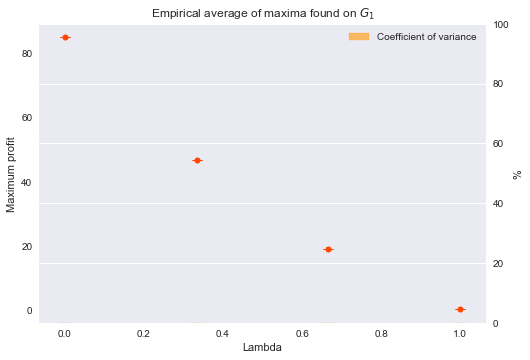

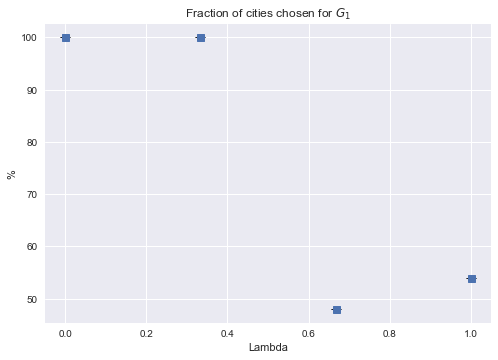

In [ ]:
# Uncomment this to plot the optimal values found before
# plot_multiple_simulations([{"optimal": optimal, "optimal_cities": opt_cities}])

In [ ]:
simulations = load_multiple_simulations("simulations", "complete_g1")

(40,)


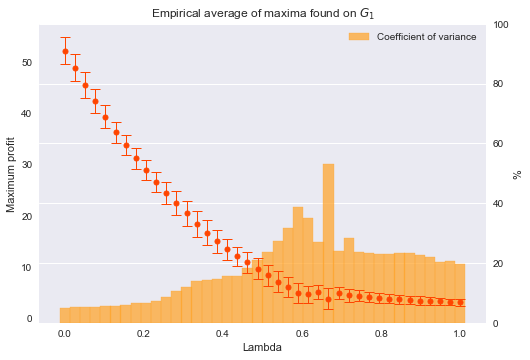

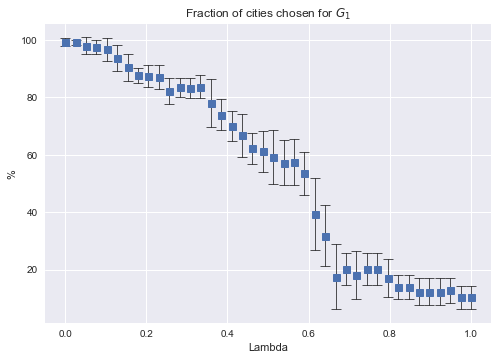

In [ ]:
plot_multiple_simulations(simulations)

#### Plot circle around chosen cities

NameError: name 'maximiser_state' is not defined

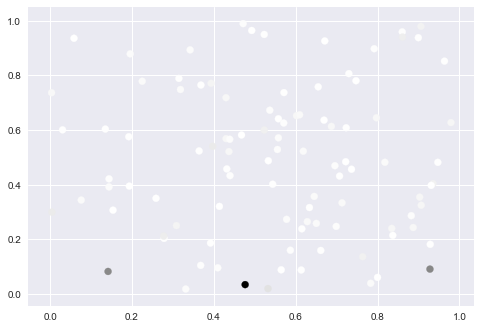

In [ ]:
# @Matteo: I guess there were breaking changes (@Youssef, can you fix it?)

# plot all cities
x1,x2 =cities[0][:, 0], cities[0][:, 1]
values = cities[1]

fig, ax = plt.subplots(1)
ax.scatter(x=x1, y=x2, c=values)

# highlight choosen region
x = cities[0][maximiser_state]
def circle_from_choosen_points(x):
  idx1, idx2 = np.unravel_index(np.argmax(euclidean_distances(x,x)) ,euclidean_distances(x,x).shape)
  radius = np.max(euclidean_distances(x,x))/2
  center = (x[idx1] + x[idx2])/2
  return center, radius

center, r = circle_from_choosen_points(x)

# making sure maximiser is logical
def inside_circle(city_loc, center, radius):
  return (euclidean_distances([city_loc],[center])-radius)[0][0] <1e-2

inside_circle_state =np.array([inside_circle(city_loc, center, r) for city_loc in cities[0] ])
print("Solution passes the test: ", np.array_equal(maximiser_state,inside_circle_state) )

theta = np.linspace(0, 2*np.pi, 100)

x1 = r*np.cos(theta) + center[0]
x2 = r*np.sin(theta) + center[1]

ax.plot(x1, x2)
ax.set_aspect(1)

plt.grid(linestyle='--')




## References
[1](http://www.scielo.org.mx/pdf/cys/v21n3/1405-5546-cys-21-03-00493.pdf) Logarithmic cooling strategy